<a href="https://colab.research.google.com/github/Wojtek130/Neural-Networks/blob/main/nn_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2

**Submission deadlines:**
- get at least 4 points by 12.03.2024 (Tue groups)
- get at least next 4 points by 19.03.2024 (Tue groups)
- remaining points: by 26.03.2024 (Tue groups)

**Points:** Aim to get 16 out of 18+ possible points

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`
![Picture title](https://github.com/rnoxy/dl_uwr/blob/summer2024/Assignments/image-20220302-183151.png?raw=1)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

## Extra points

You can earn extra 2 points if all your experiments are logged with [Weights and Biases](http://wandb.ai)


# Problems


## Problem 1 [1p]:

Let's see why GPUs are useful in deep learning. Compare matrix multiplication speed for a few matrix shapes when implemented:
1. as loops in Python
2. using np.einsum
3. using numpy on CPU
4. using pytorch on CPU
5. using pytorch on GPU

Finally, consider two square matrices, $A$ and $B$. We have 4 possibilities of multiplying them or their transpositions:
1. $AB$
2. $A^TB$
3. $AB^T$
4. $A^TB^T$

Which option is the fastest? Why?

## Problem 2: Stochastic Gradient Descent (training MNIST digits) [3p]

We provide below starter code that trains a classification model (with softmat + cross entropy loss). Alternatively, implement your own training loop and use it to solve this problem jointly with the next one.

Implement the following additions to the SGD code provided:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use the function `model.named_parameters` and select all parameters whose names contain "`weight`" rather than "`bias`".

## Problem 3: Tuning the Network for MNIST [3p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    a good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Please note: there are many hyperparameter settings that give the desired answer, some may require tuning all hyperparameters, some only a few.

## Problem 4: Convolutional Network [2p]

Use convolutional and max-pooling layers (`Conv2d`, `Max_pool2d` or their functional variants) and (without dropout) get a test error rate below 1.5%.

## Problem 5: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Please note: when using random transformations during training, make sure they are re-computed in every epoch. Consider applying augmentation either in the training loop or in the `InMemDataLoader`. For the second case, function `InMemDataLoader.__iter__` is a good place to do it.


## Problem 6: Dropout [2p]

Learn about dropout:

- implement a **dropout** layer
- or use `nn.Dropout` (then the exercise is worth 1.5 points)

and try to train a
network getting below 1.5% test error rates with dropout, but no convolutions, or below 1% when dropout is used jointly with convolutions!

Remember to turn off dropout during testing, using `model.train()` and `model.eval()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

## Problem 7: Batch Normalization [2p]

[Batch Normalization](https://arxiv.org/abs/1502.03167) helps training neural networks because it [normalizes layer activation magnitudes](https://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf). It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

## Problem 8: Norm Constraints [1p]

Implement norm constraints, i.e. instead of weight decay, that tries to set all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

## Problem 9: Hyperparameter tuner [2p]

Implement a hyper-parameter tuner able to optimize the learning rate schedule, number of neurons, and similar hyperparameters. To start, use a random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

## Problem 10: Pruning [1p]

Prune the MNIST network to retain validation accuracy no worse than 0.1 percentage point at maximum sparsity (maximal number of weights removed from the network).

One way to do it is to
1. train the network,
2. set to zero the smallest weights (typically you can zero up to 50% of weights)
3. retrain the network, keeping the zeroed weights zeroed, and repeat

## Problem 11: Other tricks [1p-many]

The neural network literature is full of tricks for training neural networks. Find some and implement them. Please note: the number of points depends on the hardness of the extension you want to implement. If in doubt, consult the TA beforehand

# Starter code

The code below trains a SoftMax regression model in PyTorch. It can easily be extended into a full multilayer neural network.

In [ ]:
%matplotlib inline

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset, random_split

import random
import timeit

In [ ]:
# problem 1

def create_two_random_matrices(a, b, c):
    # a, b, c - sizes
    m1 = [[random.randint(1, 10) for __ in range(b)] for _ in range(a)]
    m2 = [[random.randint(1, 10) for __ in range(c)] for _ in range(b)]
    return m1, m2

def matrix_multiply_loops(m1, m2):
    a = len(m1)
    b = len(m2)
    c = len(m2[0])
    result = [[0 for __ in range(c)] for _ in range(a)]
    for i in range(a):
        for j in range(c):
            for k in range(b):
                result[i][j] += (m1[i][k] * m2[k][j])
    return result

m1, m2 = create_two_random_matrices(100, 100, 100)
m1_np = np.array(m1)
m2_np = np.array(m2)
m1_torch = torch.tensor(m1)
m2_torch = torch.tensor(m2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
m1_torch_cuda = torch.tensor(m1, dtype=torch.float, device=device)
m2_torch_cuda = torch.tensor(m2, dtype=torch.float, device=device)


# Loops in Python
loops_time = timeit.timeit(lambda: matrix_multiply_loops(m1, m2), number=1)
print(f"Loops in Python: {loops_time:.6f} seconds")

# Using np.einsum
einsum_time = timeit.timeit(lambda: np.einsum('ik,kj->ij', m1, m2), number=1)
print(f"Using np.einsum: {einsum_time:.6f} seconds")

# Using NumPy on CPU
numpy_time = timeit.timeit(lambda: np.dot(m1, m2), number=1)
print(f"Using NumPy on CPU: {numpy_time:.6f} seconds")

# Using PyTorch on CPU
pytorch_cpu_time = timeit.timeit(lambda: torch.matmul(m1_torch, m2_torch), number=1)
print(f"Using PyTorch on CPU: {pytorch_cpu_time:.6f} seconds")

# Using PyTorch on GPU
if torch.cuda.is_available():
    pytorch_gpu_time = timeit.timeit(lambda: torch.matmul(m1_torch_cuda, m2_torch_cuda), number=1)
    print(f"Using PyTorch on GPU: {pytorch_gpu_time:.6f} seconds")
else:
    print("CUDA not available. Skipping GPU calculation.")
# print(matrix_multiply_loops(m1, m2))
# print(m1_np @ m2_np)


cuda
Loops in Python: 0.171640 seconds
Using np.einsum: 0.001823 seconds
Using NumPy on CPU: 0.002060 seconds
Using PyTorch on CPU: 0.000569 seconds
Using PyTorch on GPU: 0.000500 seconds


In [ ]:
# Using PyTorch on CPU
ab = 0
abt = 0
atb = 0
atbt = 0

for _ in range(100):
    m1, m2 = create_two_random_matrices(100, 100, 100)
    m1_np = np.array(m1)
    m2_np = np.array(m2)
    m1_torch = torch.tensor(m1)
    m2_torch = torch.tensor(m2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    m1_torch_cuda = torch.tensor(m1, dtype=torch.float, device=device)
    m2_torch_cuda = torch.tensor(m2, dtype=torch.float, device=device)
    ab_time = timeit.timeit(lambda: torch.matmul(m1_torch, m2_torch), number=1)
    # print(f"AB: {pytorch_cpu_time:.6f} seconds")

    abt_time = timeit.timeit(lambda: torch.matmul(m1_torch, m2_torch.T), number=1)
    # print(f"AB^T: {pytorch_cpu_time:.6f} seconds")

    atb_time = timeit.timeit(lambda: torch.matmul(m1_torch.T, m2_torch), number=1)
    # print(f"A^TB: {pytorch_cpu_time:.6f} seconds")

    atbt_time = timeit.timeit(lambda: torch.matmul(m1_torch.T, m2_torch.T), number=1)
    # print(f"A^TB^T: {pytorch_cpu_time:.6f} seconds")

    if ab_time > abt_time and ab_time > atb_time and ab_time > atbt_time:
        ab += 1
    if abt_time > ab_time and abt_time > atb_time and abt_time > atbt_time:
        abt += 1
    if atb_time > ab_time and atb_time > abt_time and atb_time > atbt_time:
        atb += 1
    if atbt_time > ab_time and atbt_time > abt_time and atbt_time > atb_time:
        atbt += 1

print(f"AB : {ab}")
print(f"AB^T : {abt}")
print(f"A^TB : {atb}")
print(f"A^TB^T : {atbt}")



AB : 21
AB^T : 33
A^TB : 13
A^TB^T : 33


In [ ]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

## Data loading

Training speed is important. By default, data is loaded on the CPU, then shipped in batches to the GPU. For this exercise, we will load the full dataset onto the GPU, which speeds up training.

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

```python
# Monkey-patch MNIST to use a more robust MNIST mirror
torchvision.datasets.MNIST.resources = [
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3",
    ),
    (
        "https://web.archive.org/web/20150906081542/http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c",
    ),
]
```

In [ ]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-59-f2b633125296>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## SGD implementation

We provide below a scaffolding for SGD. You will need to fill the TODOs while solving the assignments.

In [ ]:
# def SGD(
#     model,
#     data_loaders,
#     alpha=1e-4,
#     epsilon=0.0,
#     decay=0.0,
#     num_epochs=1,
#     max_num_epochs=np.nan,
#     patience_expansion=1.5,
#     log_every=100,
#     device="cpu",
# ):

#     # Put the model in train mode, and move to the evaluation device.
#     model.train()
#     model.to(device)
#     for data_loader in data_loaders.values():
#         if isinstance(data_loader, InMemDataLoader):
#             data_loader.to(device)

#     #
#     # TODO for Problem 2.3: Initialize momentum variables
#     # Hint: You need one velocity matrix for each parameter
#     #
#     velocities = [None for _ in model.parameters()]
#     #
#     iter_ = 0
#     epoch = 0
#     best_params = None
#     best_val_err = np.inf
#     history = {"train_losses": [], "train_errs": [], "val_errs": []}
#     print("Training the model!")
#     print("Interrupt at any time to evaluate the best validation model so far.")
#     try:
#         tstart = time.time()
#         siter = iter_
#         while epoch < num_epochs:
#             model.train()
#             epoch += 1
#             if epoch > max_num_epochs:
#                 break
#             #
#             # TODO: You can implement learning rate control here (it is updated
#             # once per epoch), or below in the loop over minibatches.
#             #

#             for x, y in data_loaders["train"]:
#                 x = x.to(device)
#                 y = y.to(device)
#                 iter_ += 1
#                 # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
#                 out = model(x)
#                 loss = model.loss(out, y)
#                 loss.backward()
#                 _, predictions = out.max(dim=1)
#                 batch_err_rate = (predictions != y).sum().item() / out.size(0)

#                 history["train_losses"].append(loss.item())
#                 history["train_errs"].append(batch_err_rate)

#                 # disable gradient computations - we do not want torch to
#                 # backpropagate through the gradient application!
#                 with torch.no_grad():
#                     for (name, p), v in zip(model.named_parameters(), velocities):
#                         if "weight" in name:
#                             #
#                             # TODO for Problem 2.3: Implement weight decay (L2 regularization
#                             # on weights by changing the gradients
#                             # p.grad += TODO
#                             #
#                             pass

#                         #
#                         # TODO for Problem 2.2: Implement a learning rate schedule
#                         # Hint: You can use the iteration or epoch counters
#                         # alpha = TODO
#                         #

#                         #
#                         # TODO for Problem 2.1: If needed, implement here a momentum schedule
#                         # epsilon = TODO
#                         #

#                         #
#                         # TODO for Problem 2.1: Implement velocity updates for momentum
#                         # lease make sure to modify the contents of v, not the v pointer!!!
#                         #
#                         # v[...] = TODO

#                         #
#                         # TODO for Problem 2: Set a more sensible learning rule here,
#                         #       using your learning rate schedule and momentum
#                         #
#                         p -= alpha * p.grad

#                         # Zero gradients for the next iteration
#                         p.grad.zero_()

#                 if iter_ % log_every == 0:
#                     num_iter = iter_ - siter + 1
#                     print(
#                         "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
#                             iter_,
#                             loss.item(),
#                             batch_err_rate * 100.0,
#                             num_iter / (time.time() - tstart),
#                         )
#                     )
#                     tstart = time.time()

#             val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
#             history["val_errs"].append((iter_, val_err_rate))

#             if val_err_rate < best_val_err:
#                 # Adjust num of epochs
#                 num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
#                 best_epoch = epoch
#                 best_val_err = val_err_rate
#                 best_params = [p.detach().cpu() for p in model.parameters()]
#             clear_output(True)
#             m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
#                 epoch, val_err_rate * 100.0, num_epochs
#             )
#             print("{0}\n{1}\n{0}".format("-" * len(m), m))

#     except KeyboardInterrupt:
#         pass

#     if best_params is not None:
#         print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
#         with torch.no_grad():
#             for param, best_param in zip(model.parameters(), best_params):
#                 param[...] = best_param
#     plot_history(history)

In [ ]:
# ***LEARNING RATE SCHEDULE (2.2)
def learning_rate_schedule(epoch, alpha):
    if epoch < 10:
        return alpha
    elif epoch < 50:
        return alpha / epoch
    else:
        return alpha * 0.01

def learning_rate_schedule_2(batch_number = 0):
    alpha = 0.01
    if batch_number < 10000:
        return alpha
    return alpha / 2

def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.9,  # Momentum parameter
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    # Initialize velocities for momentum
    velocities = [torch.zeros_like(param) for param in model.parameters()]

    # Initialize learning rate scheduler


    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            # ***LEARNING RATE SCHEDULE (2.2)
            num_iter = iter_ - siter + 1
            # alpha = learning_rate_schedule_2(num_iter)
            alpha = learning_rate_schedule(epoch, alpha)

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                with torch.no_grad():
                    for (name, param), velocity in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            # WEIGHT DECAY (2.3)
                            # decay * param is a derivative of lambda(decay) * |w(param)|^2
                            param.grad += decay * param

                        # MOMENTUM (update momentum) (2.1)
                        if epsilon != 0:
                            # velocity = eps * velocity + gradient
                            velocity.mul_(epsilon).add_(param.grad)

                        #  MOMENTUM  (Update parameters) (2.1)
                        param -= alpha * velocity

                        # Zero gradients for the next iteration
                        param.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(f"current batch: {num_iter}")
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            model.eval()

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def SGD_with_norm_constraints(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.9,  # Momentum parameter
    max_norm=1.0,  # Maximum allowed norm  (NORM CONSTRAINT 2.8)
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)

    # Initialize velocities for momentum
    velocities = [torch.zeros_like(param) for param in model.parameters()]

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                with torch.no_grad():
                    for (name, param), velocity in zip(model.named_parameters(), velocities):
                        if "weight" in name:
                            # Update momentum
                            if epsilon != 0:
                                velocity.mul_(epsilon).add_(param.grad)

                            # Update parameters
                            param -= alpha * velocity

                            # Clip gradients to prevent exploding gradients
                            nn.utils.clip_grad_norm_(param, max_norm)  # Maximum allowed norm  (NORM CONSTRAINT 2.8)

                        # Zero gradients for the next iteration
                        param.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(f"current batch: {num_iter}")
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

# Usage


In [ ]:
class MyMNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation transforms (2.4)
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),                           # Rotate by a random angle between -5 and 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),       # Random translation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),           # Adjust brightness and contrast
    transforms.ToTensor()
])

# # Load MNIST dataset with augmentation
# mnist_train_augmented = MyMNISTDataset(MNIST(root='./data', train=True, download=True), transform=augmentation_transform)
# mnist_test = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# # Define data loaders
# batch_size = 64
# train_loader = DataLoader(mnist_train_augmented, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Increase number of neurons
            nn.ReLU(),  # Activation function
            nn.Linear(512, 256),  # Another hidden layer
            nn.ReLU(),  # Activation function
            nn.Linear(256, 128),  # Another hidden layer
            nn.ReLU(),  # Activation function
            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)

import torch.nn as nn
import torch.nn.functional as F

class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),  # Increase number of neurons
            nn.BatchNorm1d(512),  # Batch normalization
            nn.ReLU(),  # Activation function
            nn.Linear(512, 256),  # Another hidden layer
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(),  # Activation function
            nn.Linear(256, 128),  # Another hidden layer
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),  # Activation function
            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# DROPOUT (2.6)
class MyModelWithDropoutAndRegularization(nn.Module):
    def __init__(self):
        super(MyModelWithDropoutAndRegularization, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer with probability of 0.5
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer with probability of 0.5
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer with probability of 0.5
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)


In [ ]:
class MyModelConv(nn.Module):
    def __init__(self):
        super(MyModelConv, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel, 32 output channels, 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 input channels, 64 output channels, 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )
        self.fc_layers = nn.Sequential( # fully connected layers (classification)
            nn.Linear(64 * 7 * 7, 512),  # 64 channels * 7x7 image size after max pooling, 512 output neurons
            nn.ReLU(),
            nn.Linear(512, 128),  # Another hidden layer
            nn.ReLU(),
            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.fc_layers(x)
        return x

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyModelConvWithDropout(nn.Module):
    def __init__(self):
        super(MyModelConvWithDropout, self).__init__()
        p_dropout = 0.1
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 input channel, 32 output channels, 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Dropout2d(p=p_dropout),  # Dropout layer with probability of 0.2 after first max pooling
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 32 input channels, 64 output channels, 3x3 kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Dropout2d(p=p_dropout)  # Dropout layer with probability of 0.2 after second max pooling
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer with probability of 0.5
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout layer with probability of 0.5
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)


In [ ]:
# class CustomDropout(nn.Module):
#     def __init__(self, p=0.5):
#         super(CustomDropout, self).__init__()
#         self.p = p

#     def forward(self, x):
#         if self.training:
#             mask = torch.bernoulli(torch.full_like(x, 1 - self.p))
#             return x * mask / (1 - self.p)
#         else:
#             return x

class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super(CustomDropout, self).__init__()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.dropout(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EnhancedModel(nn.Module):
    def __init__(self):
        super(EnhancedModel, self).__init__()
        p_dropout = 0.2

        # Convolutional layers with batch normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            # nn.BatchNorm2d(32),  # Batch normalization layer
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64),  # Batch normalization layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            CustomDropout(p_dropout)
        )

    #    BATCH NORMALIZATION (2.7)
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 14 * 14, 512),
            # nn.BatchNorm1d(512),  # Batch normalization layer
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(512, 256),
            # nn.BatchNorm1d(256),  # Batch normalization layer
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),  # Batch normalization layer
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def loss(self, outputs, targets):
        return F.cross_entropy(outputs, targets)


----------------------------------------------------------
After epoch 50 | valid err rate:  2.52% | doing  74 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 49)

-------------------------------------------
Test error rate: 2.370%, training took 66s.
-------------------------------------------


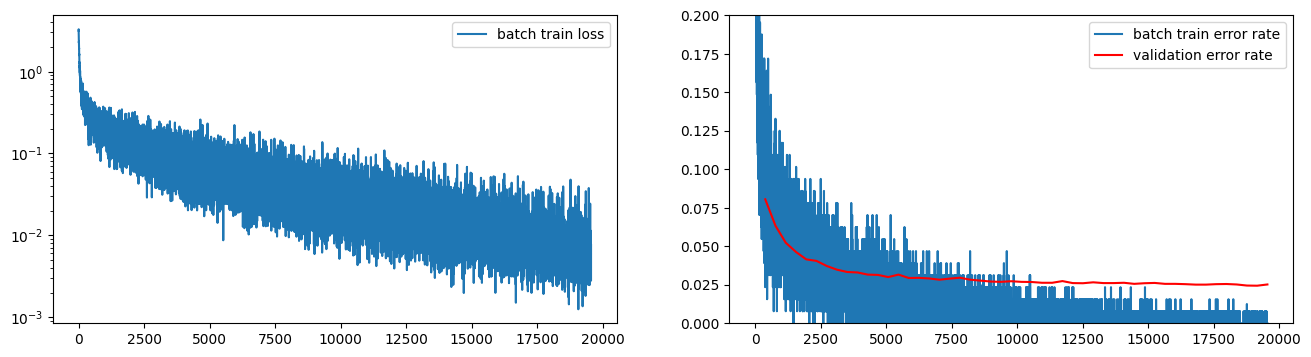

In [ ]:
# model = MyModel()
model = MyModel()

# model = MyModelWithDropoutAndRegularization()
# model = MyModelConv()
# model = MyModelConvWithDropout()
# model = EnhancedModel()



# Adjusted weight initialization
with torch.no_grad():
    for name, p in model.named_parameters():
        if "weight" in name:
            # nn.init.kaiming_normal_(p)  # Kaiming initialization
            nn.init.kaiming_uniform_(p, mode='fan_in', nonlinearity='relu') # He initialization
            # nn.init.xavier_uniform_(p)
        elif "bias" in name:
            p.zero_()
            # nn.init.constant_(p, 0.0)

# MAIN
t_start = time.time()
# SGD(model, mnist_loaders, alpha=1e-3, max_num_epochs=50)
# SGD(model, mnist_loaders, alpha=1e-3, max_num_epochs=50, device="cuda")
SGD_with_norm_constraints(model, mnist_loaders, alpha=1e-3, max_num_epochs=50, device="cuda", max_norm=1.0)



# mnist_dataset = MNIST(root='./data', train=True, download=True, transform=augmentation_transform)

# Evaluate test error rate
test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

----------------------------------------------------------
After epoch  2 | valid err rate: 23.35% | doing   2 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 1)

Best hyperparameters: {'learning_rate': 0.01, 'neurons': 128, 'alpha_decay': 0.2}
Best validation error: 0.211


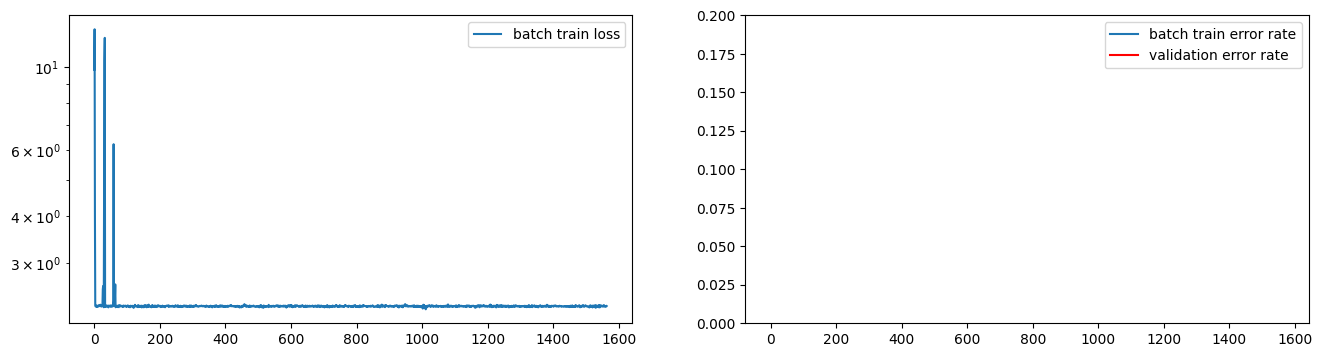

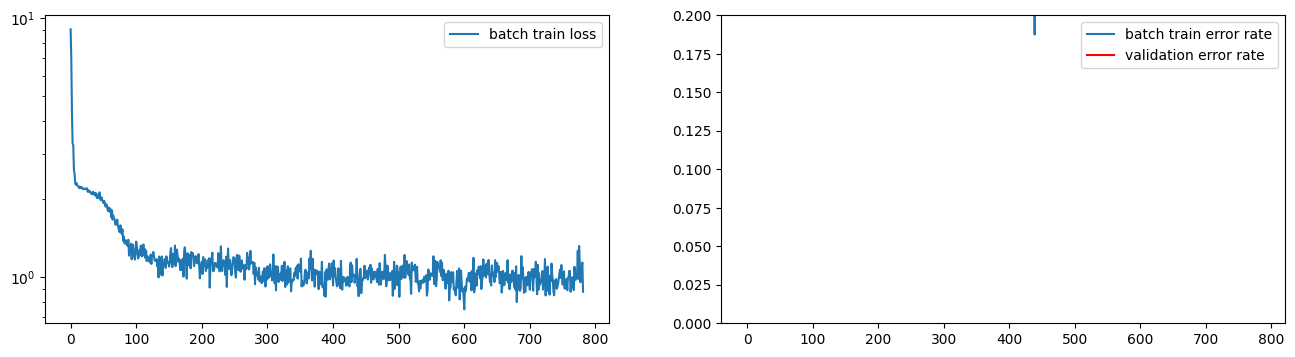

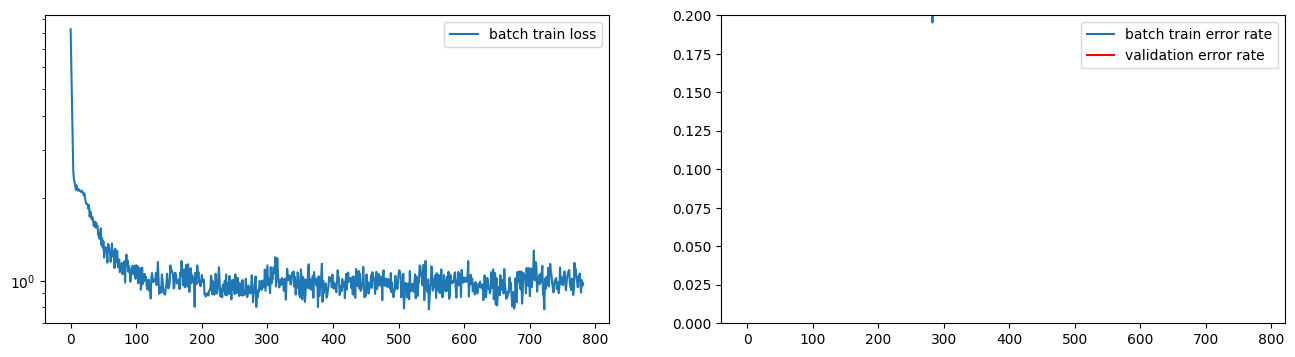

In [ ]:
import random

# HYPER-PARAMETERS (2.9)
hyperparameters_space = {
    'learning_rate': [0.001, 0.01, 0.1],
    'neurons': [64, 128, 256],
    'alpha_decay': [0.0, 0.1, 0.2],  # Example additional hyperparameter
}

max_epochs = 10

num_trials = 3

best_hyperparameters = None
best_validation_error = float('inf')

for _ in range(num_trials):
    # Randomly sample hyperparameters from the search space
    hyperparameters = {
        param: random.choice(values) for param, values in hyperparameters_space.items()
    }

    model = MyModelConvWithDropout()

    with torch.no_grad():
        for name, p in model.named_parameters():
            if "weight" in name:
                nn.init.kaiming_uniform_(p, mode='fan_in', nonlinearity='relu')
            elif "bias" in name:
                p.zero_()

    SGD(model, mnist_loaders, alpha=hyperparameters['learning_rate'],
        max_num_epochs=max_epochs, device="cuda", decay=hyperparameters.get('alpha_decay', 0.0))

    validation_error = compute_error_rate(model, mnist_loaders["valid"])

    if validation_error < best_validation_error:
        best_hyperparameters = hyperparameters
        best_validation_error = validation_error

print("Best hyperparameters:", best_hyperparameters)
print("Best validation error:", best_validation_error)


----------------------------------------------------------
After epoch 19 | valid err rate:  3.34% | doing  19 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 12)

--------------------------------------------
Test error rate: 2.480%, training took 668s.
--------------------------------------------


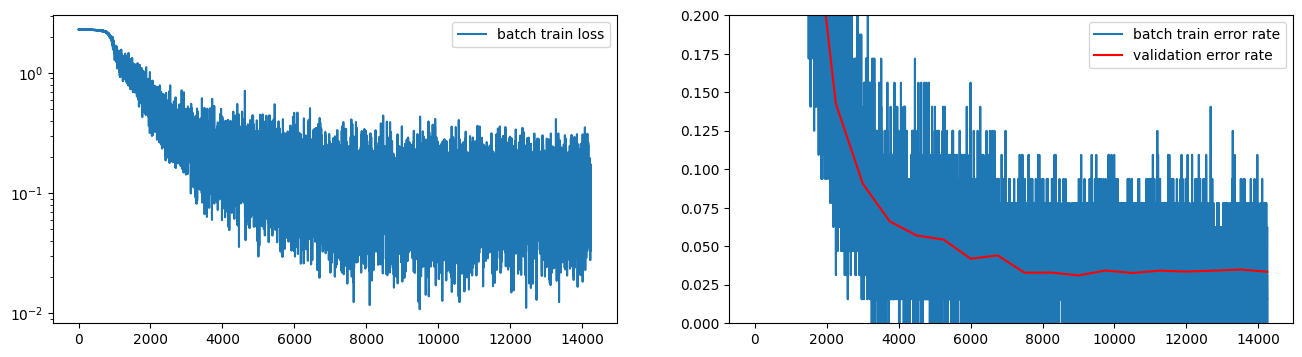

In [ ]:
model = MyModelConv()
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=augmentation_transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(mnist_dataset))
valid_size = len(mnist_dataset) - train_size
mnist_train, mnist_valid = random_split(mnist_dataset, [train_size, valid_size])

# DATA AUGMENTATION (2.5)
batch_size = 64
mnist_test = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
t_start = time.time()
SGD(model, {"train": train_loader, "test": test_loader, "valid": valid_loader}, alpha=1e-3, max_num_epochs=30, device="cuda")


# Evaluate test error rate
test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

----------------------------------------------------------
After epoch  4 | valid err rate: 10.37% | doing   4 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 2)

-------------------------------------------
Test error rate: 10.490%, training took 2s.
-------------------------------------------


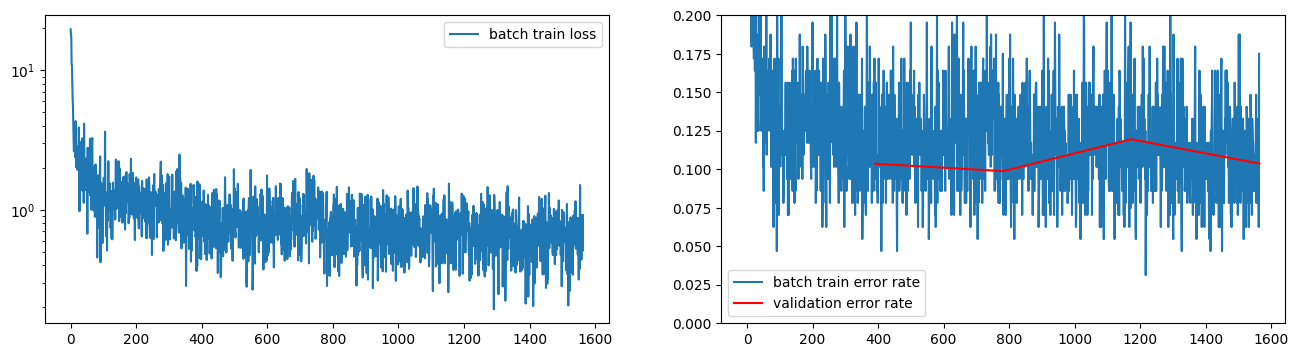

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(nn.Linear(28 * 28, 10))

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.5)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=1e-1, max_num_epochs=30, device="cuda")


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))